## checking connection to database
#connecting python to sql database, data analysis in python


In [7]:

import psycopg2

# Replace the following connection parameters with your database details
db_params = {
    'dbname': 'bugzilla',
    'user': 'postgres',
    'password': 'databayes',
    'host': 'localhost', # Typically 'localhost' for a local database
    'port': '5432'   # Typically 5432 for PostgreSQL
}

try:
    # Step 1: Connect to the PostgreSQL database
    connection = psycopg2.connect(**db_params)

    # Step 2: Create a cursor to interact with the database
    cursor = connection.cursor()

    # Step 3: Execute SQL queries
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Database version:", db_version[0])
    

    # Step 4: (Optional) Execute more SQL queries or perform other database operations here
     # Step 4: Fetch and print the results

    # Step 5: Close the cursor and connection
#     cursor.close()
#     connection.close()

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to the database:", error)


Database version: PostgreSQL 15.3, compiled by Visual C++ build 1914, 64-bit


In [181]:
def print_table(table_name):
        # Step 3: Execute a SELECT query to fetch data from the table
        query = f"SELECT * FROM {table_name};"
        cursor.execute(query)

        # Step 4: Fetch and print the results
        rows = cursor.fetchall()
        if len(rows) > 0:
            # Print column headers
            column_names = [desc[0] for desc in cursor.description]
            print("\t".join(column_names))

            # Print each row
#             for row in rows:
#                 print("\t".join(str(item) for item in row))
        else:
            print("Table is empty.")

# Call the function with the name of the table you want to print
table_name_to_print = 'for_users.aggregate_bugs'
print_table(table_name_to_print)

id	update_token	url	classification	component	status	version	product	platform	resolution	severity	op_sys	op_group	type	target_milestone	priority	creator_id	assigned_id	qa_id	mentor_id	is_open	is_confirmed	cf_last_resolved	is_cc_accessible	is_creator_accessible	summary	dupe_of	votes	last_change_time	creation_time	count_history	count_changes	count_comments	count_duplicates	count_cc	count_keywords	count_blocks


## function for creating graph of named column

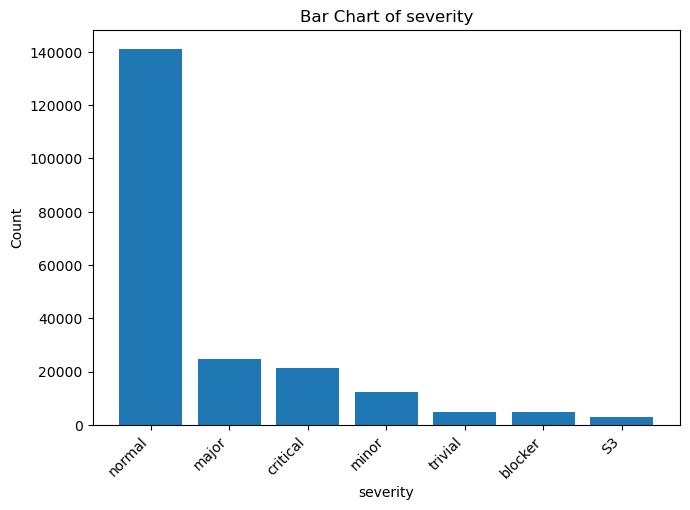

In [105]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

def fetch_data_as_dataframe(column_name, table_name, threshold):
    try:
        # Step 1: Connect to the PostgreSQL database
        connection = psycopg2.connect(**db_params)

        # Step 2: Create a cursor to interact with the database
        cursor = connection.cursor()

        # Step 3: Execute a query to retrieve the data and combine 'Other' counts
        query = f"""
            SELECT
                CASE
                    WHEN {column_name} IN (
                        SELECT {column_name}
                        FROM {table_name}
                        GROUP BY {column_name}
                        HAVING COUNT(*) > {threshold}
                    ) THEN {column_name}
                    ELSE 'Other'
                END AS {column_name},
                COUNT(*) AS count
            FROM {table_name}
            GROUP BY {column_name}
            HAVING COUNT(*) > {threshold}
            ORDER BY count DESC;
        """
        cursor.execute(query)

        # Step 4: Fetch the data and store it in a pandas DataFrame
        column_data = cursor.fetchall()
        df_classified_filtered = pd.DataFrame(column_data, columns=[column_name, 'count'])

        # Step 5: Close the cursor and connection
        cursor.close()
        connection.close()

        return df_classified_filtered

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to the database:", error)
        return None

# Replace 'your_column_name' and 'your_table_name' with the desired column name and table name
column_name_to_fetch = 'severity'
table_name_to_fetch = 'for_users.aggregate_bugs'
threshold=2000

# Call the function to retrieve data and store it as a pandas DataFrame
df_classified_filtered = fetch_data_as_dataframe(column_name_to_fetch, table_name_to_fetch, threshold)

# Shorten the x-labels (Example: Take the first 10 characters)
df_classified_filtered[column_name_to_fetch] = df_classified_filtered[column_name_to_fetch].str[:20]

# Create a bar chart to visualize the data
# plt.figure(figsize=(5, 5))
# plt.pie(df_classified_filtered['count'], labels=df_classified_filtered[column_name_to_fetch], autopct='%1.1f%%', startangle=140)
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title(f'Bug {column_name_to_fetch}')
# plt.show()

plt.figure(figsize=(7, 5))
plt.bar(df_classified_filtered[column_name_to_fetch], df_classified_filtered['count'])
plt.xlabel(column_name_to_fetch)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title(f'Bar Chart of {column_name_to_fetch}')
plt.show()


## function for creating table

In [140]:
def table_summary(table_name, column_name, count_column):
    try:
        # Step 1: Connect to the PostgreSQL database
        connection = psycopg2.connect(**db_params)

        # Step 2: Create a cursor to interact with the database
        cursor = connection.cursor()

        # Step 3: Execute a query to retrieve the data and combine 'Other' counts
        query = f""" select {column_name},
        SUM ({count_column}) as "Total changes",
        Round(avg ({count_column})::numeric, 2) as "Average changes",
        max({count_column}) as "Max changes",
        Round(stddev({count_column})::numeric,2) as "Standard deviation"
                    FROM {table_name} 
                    GROUP BY {column_name} order by "Total changes" DESC
        
        """
        cursor.execute(query)

        # Step 4: Fetch the data and store it in a pandas DataFrame
        column_data = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description] 
        df_summary_table = pd.DataFrame(column_data, columns=column_names)

        # Step 5: Close the cursor and connection
        cursor.close()
        connection.close()

        return df_summary_table

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to the database:", error)
        return None

# Replace with the desired column name and table name
column_name = 'product'
count_column ='count_changes'
table_name = 'for_users.aggregate_bugs'
file_name= column_name+'.csv'

df_summary_table = table_summary(table_name,column_name,count_column)
# df_summary_table.to_csv(file_name)
# df_summary_table

## creating new column of time between creating and resolve

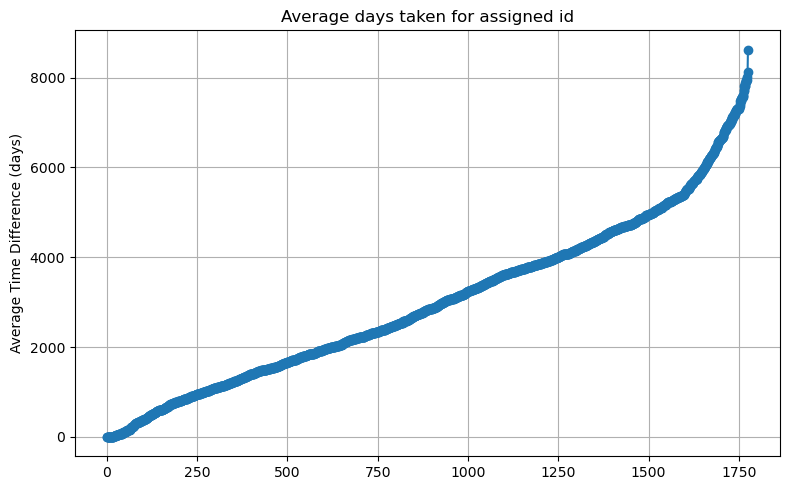

In [161]:
def table_summary(table_name, column_name_1, column_name_2, id_column):
    try:
        # Step 1: Connect to the PostgreSQL database
        connection = psycopg2.connect(**db_params)

        # Step 2: Create a cursor to interact with the database
        cursor = connection.cursor()

        # Step 3: Execute a query to retrieve the data and combine 'Other' counts
        query = f""" select {id_column},
                AVG(DATE_PART('day',{column_name_2} - {column_name_1})) AS time_difference_days
                FROM {table_name}
                GROUP BY
                {id_column} order by time_difference_days;
            
        """
        cursor.execute(query)
#         query_1 = f""" select assigned_id,
#                 Round(avg (time_difference_days)::numeric, 2) as "Average changes",
#                 FROM {table_name};

#         """
#         cursor.execute(query_1)

        # Step 4: Fetch the data and store it in a pandas DataFrame
        column_data = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description] 
        df_summary_table = pd.DataFrame(column_data, columns=column_names)

        # Step 5: Close the cursor and connection
        cursor.close()
        connection.close()

        return df_summary_table

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to the database:", error)
        return None

# Replace 'your_column_name' and 'your_table_name' with the desired column name and table name
column_name_1 = 'creation_time'
column_name_2 ='last_change_time'
table_name = 'for_users.aggregate_bugs'
id_column='assigned_id'

file_name= column_name_1+'.csv'
# Call the function to retrieve data and store it as a pandas DataFrame
df_summary_table = table_summary(table_name,column_name_1,column_name_2,id_column)
# df_summary_table.to_csv(file_name)
df_summary_table

# Add a new column 'counter' to the DataFrame as a counter from 0
df_summary_table['counter'] = range(len(df_summary_table))

# Replace 'your_line_graph_title' with the desired title for the line graph
line_graph_title = 'Average days taken for assigned id'

# Create a line graph
plt.figure(figsize=(8, 5))
plt.plot(df_summary_table['counter'], df_summary_table['time_difference_days'], marker='o', linestyle='-')
plt.ylabel('Average Time Difference (days)')
plt.title(line_graph_title)
plt.grid(True)
plt.tight_layout()
plt.show()


In [149]:
df_summary_table

,assigned_id,time_difference_days
0,9084,0.0
1,15442,0.0
2,22817,0.0
3,5916,0.0
4,53543,0.0
...,...,...
1771,687424,7941.0
1772,660012,7947.0
1773,27780,8014.0
1774,406194,8116.0


## nlp stuff

In [165]:
def table_summary(table_name, column_name):
    try:
        # Step 1: Connect to the PostgreSQL database
        connection = psycopg2.connect(**db_params)

        # Step 2: Create a cursor to interact with the database
        cursor = connection.cursor()

        # Step 3: Execute a query to retrieve the data and combine 'Other' counts
        query = f""" select {column_name} as description FROM {table_name};
            
        """
        cursor.execute(query)

        # Step 4: Fetch the data and store it in a pandas DataFrame
        column_data = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description] 
        df_summary_table = pd.DataFrame(column_data, columns=column_names)

        # Step 5: Close the cursor and connection
        cursor.close()
        connection.close()

        return df_summary_table

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to the database:", error)
        return None

column_name= 'summary'
table_name = 'for_users.aggregate_bugs'

file_name= column_name_1+'.csv'
# Call the function to retrieve data and store it as a pandas DataFrame
df_summary_table = table_summary(table_name,column_name)
# df_summary_table.to_csv(file_name)
df_summary_table

,description
0,Navigator does not free preference hash table ...
1,Floating Point Exception on Execution
2,Preference Dialog does not show
3,Close Mozilla lead to a Assert Failed
4,Bookmark properties leads to an Assert failed
...,...
213308,Backspace Makes Further Input Impossible In Co...
213309,bookmark file overwritten on upgrade from Moz ...
213310,more advanced preferences
213311,add Acrobat-style grab and scroll


In [166]:
import numpy as np
import spacy
from tqdm.notebook import tqdm
from collections import Counter, OrderedDict, defaultdict

nlp= spacy.load('en_core_web_sm')

In [168]:
# tokenizing the text
docs=df_summary_table['description']
docs=docs[:10000]
docs_tkns = []

for doc in tqdm(docs,total=len(docs)):
    tmp = [
        token.lemma_.lower()
        for token in nlp(doc)
        if (not token.is_stop) & (token.is_alpha) & (token.is_oov)
    ]
    
    docs_tkns.append(tmp)
    del tmp

  0%|          | 0/10000 [00:00<?, ?it/s]

In [169]:
voc = sorted(set(sum(docs_tkns, [])))
voc_dict = OrderedDict((word, 0) for idx, word in enumerate(voc))
for doc in tqdm(docs_tkns,total=len(docs_tkns)):
        tkns_count = Counter(doc)
        for k, v in tkns_count.items():
            voc_dict[k] = voc_dict[k]+v
        del tkns_count

  0%|          | 0/10000 [00:00<?, ?it/s]

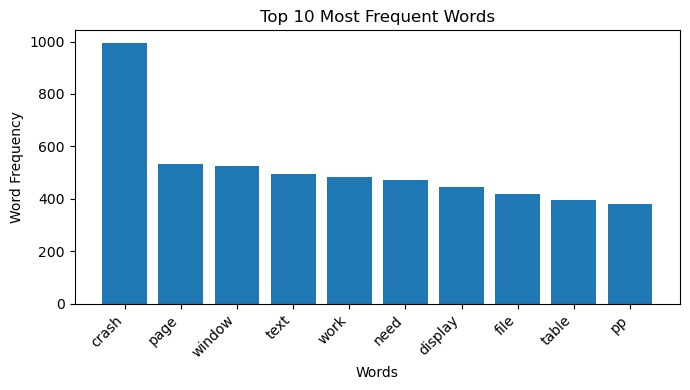

In [174]:
ordered_voc_dict = OrderedDict(sorted(voc_dict.items(), key=lambda x: x[1], reverse=True))
# Get the top N most frequent words
top_n = 10
most_frequent_words = list(ordered_voc_dict.keys())[:top_n]
word_counts = list(ordered_voc_dict.values())[:top_n]

# Create a bar graph of the most frequent words
plt.figure(figsize=(7, 4))
plt.bar(most_frequent_words, word_counts)
plt.xlabel('Words')
plt.ylabel('Word Frequency')
plt.title(f'Top {top_n} Most Frequent Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Now using tokenised docs, we can run logistic classification using doc2vec model. 

In [176]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# creating tagged document for model
tgd_quotes = [TaggedDocument(d, [i]) for i, d in enumerate(docs_tkns)] # step 2

In [177]:
# creating doc2vec model
model = Doc2Vec(
        tgd_quotes, vector_size=20, min_count=10, workers=5, epochs=20
    )
model.save("quote_embedding.model")
model = Doc2Vec.load("quote_embedding.model")

In [178]:
# inferring vector to each doc
vector_comb=[]
for doc in tqdm(docs_tkns,total=len(docs_tkns)):
    vector = model.infer_vector(doc)
    vector_comb.append(vector)
    del vector

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# this code can be modified for desired target variables, e.g. is_open

In [ ]:
# Logistic regression machine learning for binary classification 
#in this case we use is_open to determine extremely difficult to solve cases
#we one hot encode the non numeric columns to provided to training data matrix
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

#df = spark.read.csv(, header=True, inferSchema=True) 


oh_columns = [f.name for f in df.schema.fields if f.dataType not in [IntegerType(), DoubleType()]]

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in oh_columns]

encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers],
                        outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers])

assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")

pipeline = Pipeline(stages=indexers + [encoder, assembler])

df_encoded = pipeline.fit(df).transform(df)

df_encoded.show()


X_train= #vector of train data
y_train= # 'is_confirmed' label
X_test= #vector of test data
y_test= # 'is_confirmed' label

# 1. State the model you want to use
lr = LogisticRegression(max_iter=100, random_state=42)

# 2. Put training data in model
lr.fit(X_train, y_train)

# 3. Check model works on test data
y_pred = lr.predict(X_test)

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

##multinomial implementation of logistic regression for severity prediction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
X_train= #vector of train data
y_train= # 'severity' label
X_test= #vector of test data
y_test= # 'severity' label
# 1. State the model you want to use
lr = LogisticRegression(max_iter=100, random_state=42, multi_class='multinomial', solver='lbfgs')

# 2. Put training data in model
lr.fit(X_train, y_train)

# 3. Check model works on test data
y_pred = lr.predict(X_test)

print("Accuracy is ", accuracy_score(y_test, y_pred)*100)